# Metadata

```
Course:   DS 5001 
Module:   09 HW
Topic:    Word2Vec
Author:   MacKenzye Leroy
 

```

# Set Up

In [1]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
from sklearn.manifold import TSNE
from scipy.linalg import norm


In [2]:
import plotly.express as px
import seaborn as sns; sns.set()
import os

In [3]:
norm_docs = True # L2 norming
center_by_mean = True 
center_by_variance = False # Not supposed to ... Exaggerates significance of rare words
n_terms = 1000 # Number of significant words; feature space
k = 6 # Number of components

In [4]:
os.chdir('/Users/mackenzyeleroy/Documents/MSDS/DS5001/FinalProject')
home_dir = os.getcwd()
home_dir

'/Users/mackenzyeleroy/Documents/MSDS/DS5001/FinalProject'

In [5]:
data_home = f"{home_dir}/Data"
parser_lib = f"{home_dir}/lib"
source_files = f'{data_home}/output'
data_prefix = 'wells-verne'

In [6]:
OHCO = ['book_id','chap_id','para_num','sent_num','token_num']

In [7]:
Wells_w2v_params = dict(
    min_count = 50,
    #workers = 4,
    vector_size = 256,
    window = 2    
)

In [8]:
Verne_w2v_params = dict(
    min_count = 80,
    #workers = 4,
    vector_size = 256,
    window = 2    
)

In [9]:
tsne_params = dict(
    learning_rate = 200., #'auto' or [10.0, 1000.0]
    perplexity = 20,
    n_components = 2,
    init = 'random',
    n_iter = 1000,
    random_state = 42    
)

# Get Data

In [10]:
TOKENS = pd.read_csv(f"{source_files}/{data_prefix}-CORPUS.csv").set_index(OHCO)

In [11]:
TOKENS.head()

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                                
35      1       0        0        0          ('Introduction', 'NN')   NN   
                1        0        0                   ('The', 'DT')   DT   
                                  1                 ('Time', 'NNP')  NNP   
                                  2            ('Traveller', 'NNP')  NNP   
                                  3                 ('(for', 'NNP')  NNP   

                                                token_str      term_str  
book_id chap_id para_num sent_num token_num                              
35      1       0        0        0          Introduction  introduction  
                1        0        0                   The           the  
                                  1                  Time          time  
                                  2             Traveller     traveller  
                                  3                  (for           for

In [12]:
#need to seperate our CORPUS by auther ussing Gutenburg id numbers
WellsCORPUSNum = [780, 718, 6424, 5230, 36, 35, 159, 12163, 1059, 1013]
VerneCORPUSNum = [44278, 3526, 3091, 18857, 16457, 164, 1355, 1353, 1268, 103]

In [13]:
TOKENS = TOKENS.reset_index()
WellsTOKENS = TOKENS[TOKENS.book_id.isin(WellsCORPUSNum)]
VerneTOKENS = TOKENS[TOKENS.book_id.isin(VerneCORPUSNum)]
WellsTOKENS = WellsTOKENS.set_index(OHCO)
VerneTOKENS = VerneTOKENS.set_index(OHCO)
TOKENS = TOKENS.set_index(OHCO)
WellsTOKENS

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                                
35      1       0        0        0          ('Introduction', 'NN')   NN   
                1        0        0                   ('The', 'DT')   DT   
                                  1                 ('Time', 'NNP')  NNP   
                                  2            ('Traveller', 'NNP')  NNP   
                                  3                 ('(for', 'NNP')  NNP   
...                                                             ...  ...   
12163   25      45       0        14                 ('was', 'VBD')  VBD   
                                  15                 ('very', 'RB')   RB   
                                  16                ('near.', 'JJ')   JJ   
                46       0        0                   ('THE', 'DT')   DT   
                                  1                 ('END.', 'NNP')  NNP   

                                                token_str      term_str  
book_id chap_id para_num sent_num token_num                              
35      1       0        0        0          Introduction  introduction  
                1        0        0                   The           the  
                                  1                  Time          time  
                                  2             Traveller     traveller  
                                  3                  (for           for  
...                                                   ...           ...  
12163   25      45       0        14                  was           was  
                                  15                 very          very  
                                  16                near.          near  
                46       0        0                   THE           the  
                                  1                  END.           end  

[861960 rows x 4 columns]

In [14]:
VerneTOKENS 

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                            
103     1       0        0        0               ('IN', 'NNP')  NNP   
                                  1            ('WHICH', 'NNP')  NNP   
                                  2          ('PHILEAS', 'NNP')  NNP   
                                  3             ('FOGG', 'NNP')  NNP   
                                  4              ('AND', 'NNP')  NNP   
...                                                         ...  ...   
44278   28      15       1        14             ('will', 'MD')   MD   
                                  15             ('come', 'VB')   VB   
                                  16              ('out', 'RP')   RP   
                                  17              ('all', 'DT')   DT   
                                  18          ('right."', 'NN')   NN   

                                            token_str term_str  
book_id chap_id para_num sent_num token_num                     
103     1       0        0        0                IN       in  
                                  1             WHICH    which  
                                  2           PHILEAS  phileas  
                                  3              FOGG     fogg  
                                  4               AND      and  
...                                               ...      ...  
44278   28      15       1        14             will     will  
                                  15             come     come  
                                  16              out      out  
                                  17              all      all  
                                  18          right."    right  

[914683 rows x 4 columns]

In [15]:
len(TOKENS) == len(WellsTOKENS) + len(VerneTOKENS)

True

# Extract VOCAB

Use this to filter significant terms and to store w2v features and tSNE coordinates.

In [16]:
WellsVOCAB = WellsTOKENS.term_str.value_counts().to_frame('n')
WellsVOCAB.index.name = 'term_str'

In [17]:
WellsVOCAB['pos_max'] = WellsTOKENS.value_counts(['term_str','pos']).unstack().idxmax(1)

In [18]:
WellsVOCAB['pos_group'] = WellsVOCAB.pos_max.str.slice(0,2)

## Mel

In [19]:
VerneVOCAB = VerneTOKENS.term_str.value_counts().to_frame('n')
VerneVOCAB.index.name = 'term_str'

In [20]:
VerneVOCAB['pos_max'] = VerneTOKENS.value_counts(['term_str','pos']).unstack().idxmax(1)

In [21]:
VerneVOCAB['pos_group'] = VerneVOCAB.pos_max.str.slice(0,2)

# Add Chapter Significance

In [22]:
WellsCHAPS = WellsTOKENS.groupby(OHCO[:2]+['term_str']).term_str.count()\
    .unstack(fill_value=0).astype('bool').astype('int')

In [23]:
WellsCHAPS.head()

term_str         1  10  1000  10000000  101  105  107  11  12  140000000  ...  \
book_id chap_id                                                           ...   
35      1        0   0     0         0    0    0    0   0   0          0  ...   
        2        0   0     0         0    0    0    0   0   0          0  ...   
        3        0   0     0         0    0    0    0   0   0          0  ...   
        4        0   0     0         0    0    0    0   0   0          0  ...   
        5        0   0     0         0    0    0    0   0   0          0  ...   

term_str         à  â  âtrice  æsthetic  æstheticism  éclat  épicier  ō  α  β  
book_id chap_id                                                                
35      1        0  0       0         0            0      0        0  0  0  0  
        2        0  0       0         0            0      0        0  0  0  0  
        3        0  0       0         0            0      0        0  0  0  0  
        4        0  0       0         0            0      0        0  0  0  0  
        5        0  0       0         0            0      0        0  0  0  0  

[5 rows x 28510 columns]

In [24]:
WellsVOCAB['df'] = WellsCHAPS.sum()
WellsVOCAB['dfidf'] = WellsVOCAB.df * np.log2(len(WellsCHAPS)/WellsVOCAB.df)

In [25]:
WellsVOCAB.sort_values('dfidf', ascending=False)

n pos_max pos_group   df     dfidf
term_str                                        
flung       109      NN        NN   69  99.24753
mouth       136      NN        NN   69  99.24753
during      157      IN        IN   69  99.24753
talk        273      VB        VB   69  99.24753
words       154     NNS        NN   69  99.24753
...         ...     ...       ...  ...       ...
in        14522      IN        IN  187   0.00000
to        19581      TO        TO  187   0.00000
a         22780      DT        DT  187   0.00000
of        32821      IN        IN  187   0.00000
the       53614      DT        DT  187   0.00000

[28510 rows x 5 columns]

## Mel

In [26]:
VerneCHAPS = VerneTOKENS.groupby(OHCO[:2]+['term_str']).term_str.count()\
    .unstack(fill_value=0).astype('bool').astype('int')

In [27]:
VerneCHAPS.head()

term_str         0  000436  016  05  092  0h  1  10  100  1000  ...  \
book_id chap_id                                                 ...   
103     1        0       0    0   0    0   0  0   0    0     0  ...   
        2        0       0    0   0    0   0  0   0    0     0  ...   
        3        0       0    0   0    0   0  0   0    0     0  ...   
        4        0       0    0   0    0   0  0   0    0     0  ...   
        5        0       0    0   0    0   0  0   0    0     0  ...   

term_str         zoroasterthe  zostera  zouave  zouricolo  zqq  zulma  \
book_id chap_id                                                         
103     1                   0        0       0          0    0      0   
        2                   0        0       0          0    0      0   
        3                   0        0       0          0    0      0   
        4                   0        0       0          0    0      0   
        5                   0        0       0          0    0      0   

term_str         zungomoro  zvdk  à  œdipus  
book_id chap_id                              
103     1                0     0  0       0  
        2                0     0  0       0  
        3                0     0  0       0  
        4                0     0  0       0  
        5                0     0  0       0  

[5 rows x 26359 columns]

In [28]:
VerneVOCAB['df'] = VerneCHAPS.sum()
VerneVOCAB['dfidf'] = VerneVOCAB.df * np.log2(len(VerneCHAPS)/VerneVOCAB.df)

In [29]:
VerneVOCAB.sort_values('dfidf', ascending=False)

n pos_max pos_group   df       dfidf
term_str                                          
below       231      IN        IN  142  205.394854
south       275      NN        NN  142  205.394854
reason      219      NN        NN  142  205.394854
got         217     VBD        VB  143  205.393534
things      197     NNS        NN  143  205.393534
...         ...     ...       ...  ...         ...
in        14483      IN        IN  387    0.000000
a         18472      DT        DT  387    0.000000
and       23300      CC        CC  387    0.000000
to        24825      TO        TO  387    0.000000
the       72801      DT        DT  387    0.000000

[26359 rows x 5 columns]

# Get List of Token Lists

Because that's what Gensim wants.

In [30]:
WellsSENTS = WellsTOKENS.groupby(OHCO[:-1]).term_str.apply(lambda  x:  x.tolist())

In [31]:
VerneSENTS = VerneTOKENS.groupby(OHCO[:-1]).term_str.apply(lambda  x:  x.tolist())

# Learn Word Embeddings

In [32]:
WellsSENTS.head().tolist()

[['introduction'],
 ['the',
  'time',
  'traveller',
  'for',
  'so',
  'it',
  'will',
  'be',
  'convenient',
  'to',
  'speak',
  'of',
  'him',
  'was',
  'expounding',
  'a',
  'recondite',
  'matter',
  'to',
  'us'],
 ['his',
  'pale',
  'grey',
  'eyes',
  'shone',
  'and',
  'twinkled',
  'and',
  'his',
  'usually',
  'pale',
  'face',
  'was',
  'flushed',
  'and',
  'animated'],
 ['the',
  'fire',
  'burnt',
  'brightly',
  'and',
  'the',
  'soft',
  'radiance',
  'of',
  'the',
  'incandescent',
  'lights',
  'in',
  'the',
  'lilies',
  'of',
  'silver',
  'caught',
  'the',
  'bubbles',
  'that',
  'flashed',
  'and',
  'passed',
  'in',
  'our',
  'glasses'],
 ['our',
  'chairs',
  'being',
  'his',
  'patents',
  'embraced',
  'and',
  'caressed',
  'us',
  'rather',
  'than',
  'submitted',
  'to',
  'be',
  'sat',
  'upon',
  'and',
  'there',
  'was',
  'that',
  'luxurious',
  'after',
  'dinner',
  'atmosphere',
  'when',
  'thought',
  'runs',
  'gracefully',
  

In [33]:
VerneSENTS.head().tolist()

[['in',
  'which',
  'phileas',
  'fogg',
  'and',
  'passepartout',
  'accept',
  'each',
  'other',
  'the',
  'one',
  'as',
  'master',
  'the',
  'other',
  'as',
  'man'],
 ['mr', 'phileas', 'fogg', 'lived', 'in', '1872', 'at', 'no'],
 ['7',
  'saville',
  'row',
  'burlington',
  'gardens',
  'the',
  'house',
  'in',
  'which',
  'sheridan',
  'died',
  'in',
  '1814'],
 ['he',
  'was',
  'one',
  'of',
  'the',
  'most',
  'noticeable',
  'members',
  'of',
  'the',
  'reform',
  'club',
  'though',
  'he',
  'seemed',
  'always',
  'to',
  'avoid',
  'attracting',
  'attention',
  'an',
  'enigmatical',
  'personage',
  'about',
  'whom',
  'little',
  'was',
  'known',
  'except',
  'that',
  'he',
  'was',
  'a',
  'polished',
  'man',
  'of',
  'the',
  'world'],
 ['people',
  'said',
  'that',
  'he',
  'resembled',
  'byronat',
  'least',
  'that',
  'his',
  'head',
  'was',
  'byronic',
  'but',
  'he',
  'was',
  'a',
  'bearded',
  'tranquil',
  'byron',
  'who',
  '

In [34]:
WellsModel = word2vec.Word2Vec(WellsSENTS.values, **Wells_w2v_params)
VerneModel = word2vec.Word2Vec(VerneSENTS.values, **Verne_w2v_params)

In [35]:
WellsW2V = pd.DataFrame(WellsModel .wv.get_normed_vectors(), index=WellsModel .wv.index_to_key)
WellsW2V.index.name = 'term_str'
WellsW2V = WellsW2V.sort_index()

In [36]:
WellsW2V.head()

0         1         2         3         4         5    \
term_str                                                               
a         0.084182 -0.066604  0.064862 -0.004526  0.088401 -0.051543   
able     -0.047202 -0.032592  0.039621  0.002710  0.141478  0.077763   
about     0.066900 -0.089538 -0.053831 -0.029000 -0.009622 -0.017906   
above     0.021345 -0.045042 -0.051316  0.048446 -0.062592  0.021489   
abruptly -0.085394 -0.032970 -0.027776  0.011955 -0.025611 -0.054515   

               6         7         8         9    ...       246       247  \
term_str                                          ...                       
a        -0.100506 -0.010725 -0.022626 -0.093631  ... -0.037876  0.038334   
able      0.053351 -0.100767 -0.015699  0.046553  ... -0.000437  0.008948   
about     0.053672 -0.076878 -0.022351  0.015100  ...  0.079261  0.010913   
above     0.058531  0.008477 -0.025167  0.043957  ...  0.053359  0.004017   
abruptly  0.055889 -0.144571 -0.054720  0.077581  ... -0.061302  0.094034   

               248       249       250       251       252       253  \
term_str                                                               
a        -0.006334 -0.073414 -0.046482 -0.028287 -0.089577  0.133458   
able     -0.091199  0.025013 -0.045298 -0.086077  0.112419  0.027667   
about    -0.110115 -0.010903  0.009799 -0.044110 -0.070310 -0.050145   
above    -0.021495 -0.054571 -0.054293 -0.016262 -0.118532 -0.069974   
abruptly -0.090449 -0.086916  0.027595  0.019323 -0.016517  0.112546   

               254       255  
term_str                      
a         0.027529 -0.094917  
able     -0.031002  0.014149  
about    -0.014421  0.017960  
above    -0.129729  0.055865  
abruptly -0.093207  0.023353  

[5 rows x 256 columns]

In [37]:
## Verne

In [38]:
VerneW2V = pd.DataFrame(VerneModel .wv.get_normed_vectors(), index=VerneModel .wv.index_to_key)
VerneW2V.index.name = 'term_str'
VerneW2V = VerneW2V.sort_index()

In [39]:
VerneW2V.head()

0         1         2         3         4         5    \
term_str                                                                
a         -0.088618 -0.003809  0.005403 -0.023266  0.123007  0.026337   
aberfoyle -0.046970 -0.066677  0.034020  0.059942  0.056626 -0.042943   
able      -0.049339 -0.136082  0.085635  0.005877 -0.044343 -0.093270   
about      0.053295 -0.030121  0.049875 -0.068554  0.096049 -0.033111   
above      0.015298  0.006383  0.016962 -0.031734  0.046851  0.069759   

                6         7         8         9    ...       246       247  \
term_str                                           ...                       
a         -0.044933 -0.072639  0.123756  0.117004  ...  0.084459  0.032465   
aberfoyle  0.100021  0.006361  0.030268  0.062934  ...  0.069932  0.070047   
able      -0.035037 -0.060746 -0.044593 -0.119814  ...  0.052188  0.058889   
about     -0.010016  0.029778 -0.075881  0.022215  ...  0.001211 -0.015890   
above      0.061661  0.023448  0.022342  0.053634  ...  0.047871  0.042202   

                248       249       250       251       252       253  \
term_str                                                                
a          0.046870 -0.026162  0.050115 -0.036124  0.020521 -0.045953   
aberfoyle -0.053822 -0.028886 -0.093488  0.058085 -0.050498 -0.016344   
able       0.045626 -0.038121 -0.159823  0.085373  0.011444 -0.001302   
about      0.105532  0.075168 -0.015565  0.058441 -0.025345 -0.064646   
above     -0.017746  0.000487  0.018224  0.067780 -0.015033 -0.099809   

                254       255  
term_str                       
a         -0.051548 -0.010268  
aberfoyle -0.130045 -0.032291  
able      -0.059010  0.027122  
about     -0.015627  0.086131  
above     -0.027424  0.088621  

[5 rows x 256 columns]

# Visualize with tSNE

In [40]:
tsne_engine = TSNE(**tsne_params)
Wells_tsne_model = tsne_engine.fit_transform(WellsW2V)

In [41]:
WellsCOORDS = pd.DataFrame(Wells_tsne_model, columns=['x','y'], index=WellsW2V.index)\
    .join(WellsVOCAB, how='left')[['x','y','n','dfidf','pos_group']]

In [42]:
WellsCOORDS = WellsCOORDS[WellsCOORDS.dfidf.notnull()]

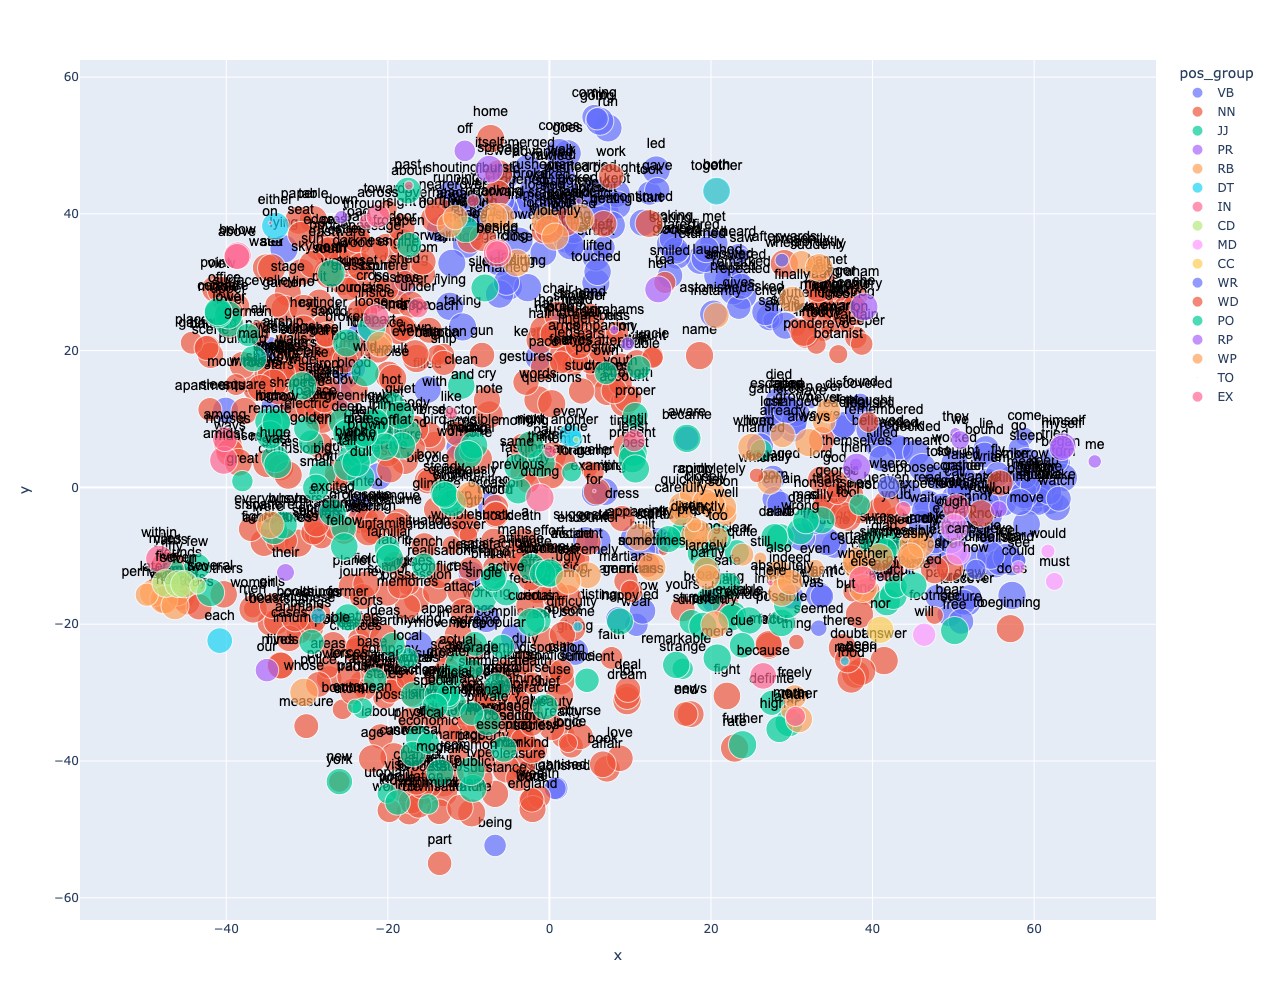

In [43]:
px.scatter(WellsCOORDS.reset_index().sample(1000), 
           'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='dfidf',           
           height=1000, width=1200).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

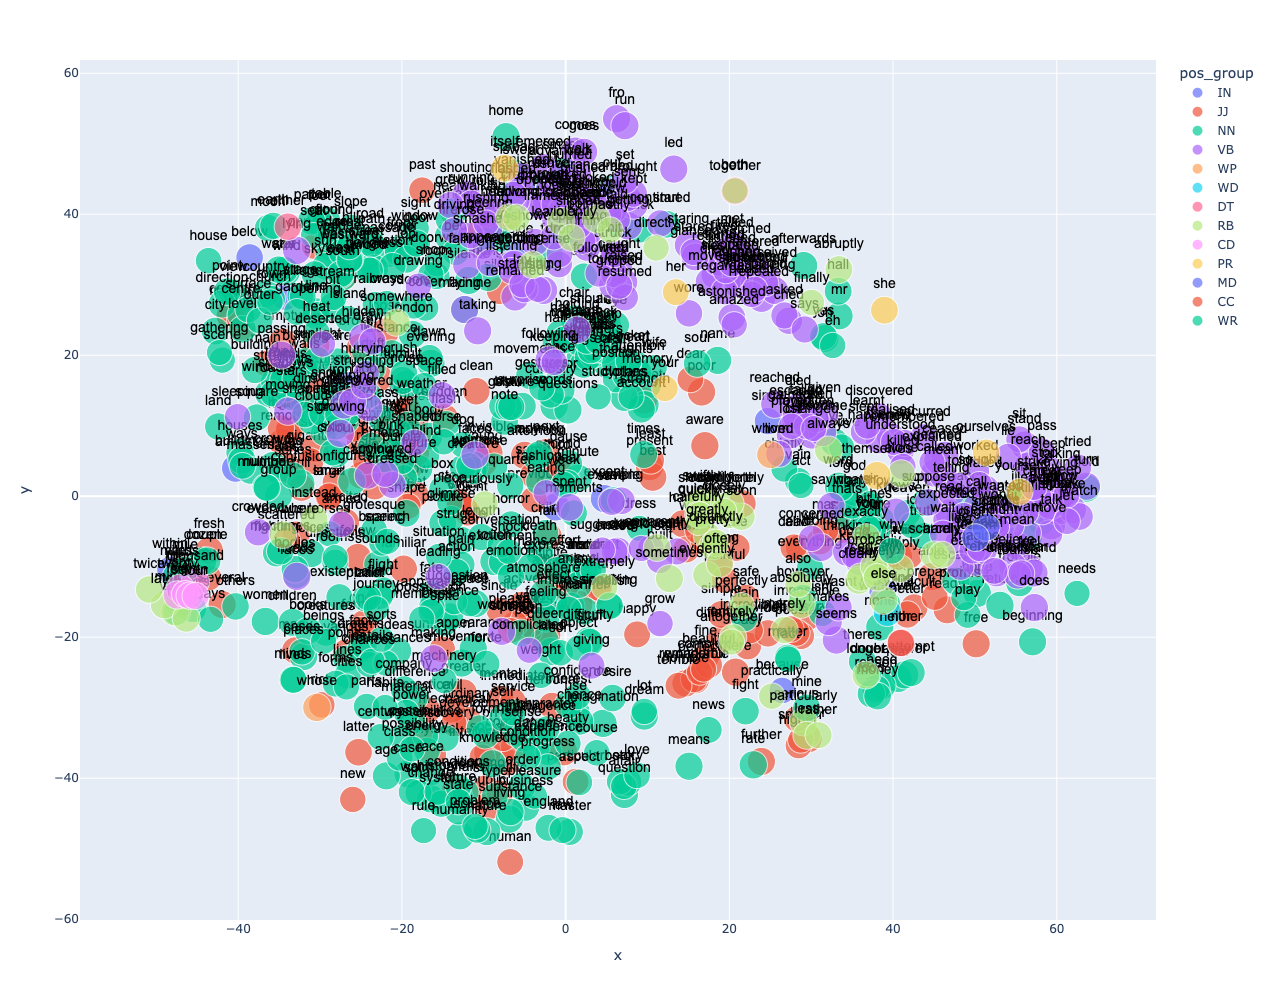

In [44]:
px.scatter(WellsCOORDS.reset_index().sort_values('dfidf', ascending=False).head(1000), 
           'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='dfidf',           
           height=1000, width=1200).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

In [45]:
tsne_engine = TSNE(**tsne_params)
Verne_tsne_model = tsne_engine.fit_transform(VerneW2V)

In [46]:
VerneCOORDS = pd.DataFrame(Verne_tsne_model, columns=['x','y'], index=VerneW2V.index)\
    .join(VerneVOCAB, how='left')[['x','y','n','dfidf','pos_group']]

In [47]:
VerneCOORDS = VerneCOORDS[VerneCOORDS.dfidf.notnull()]

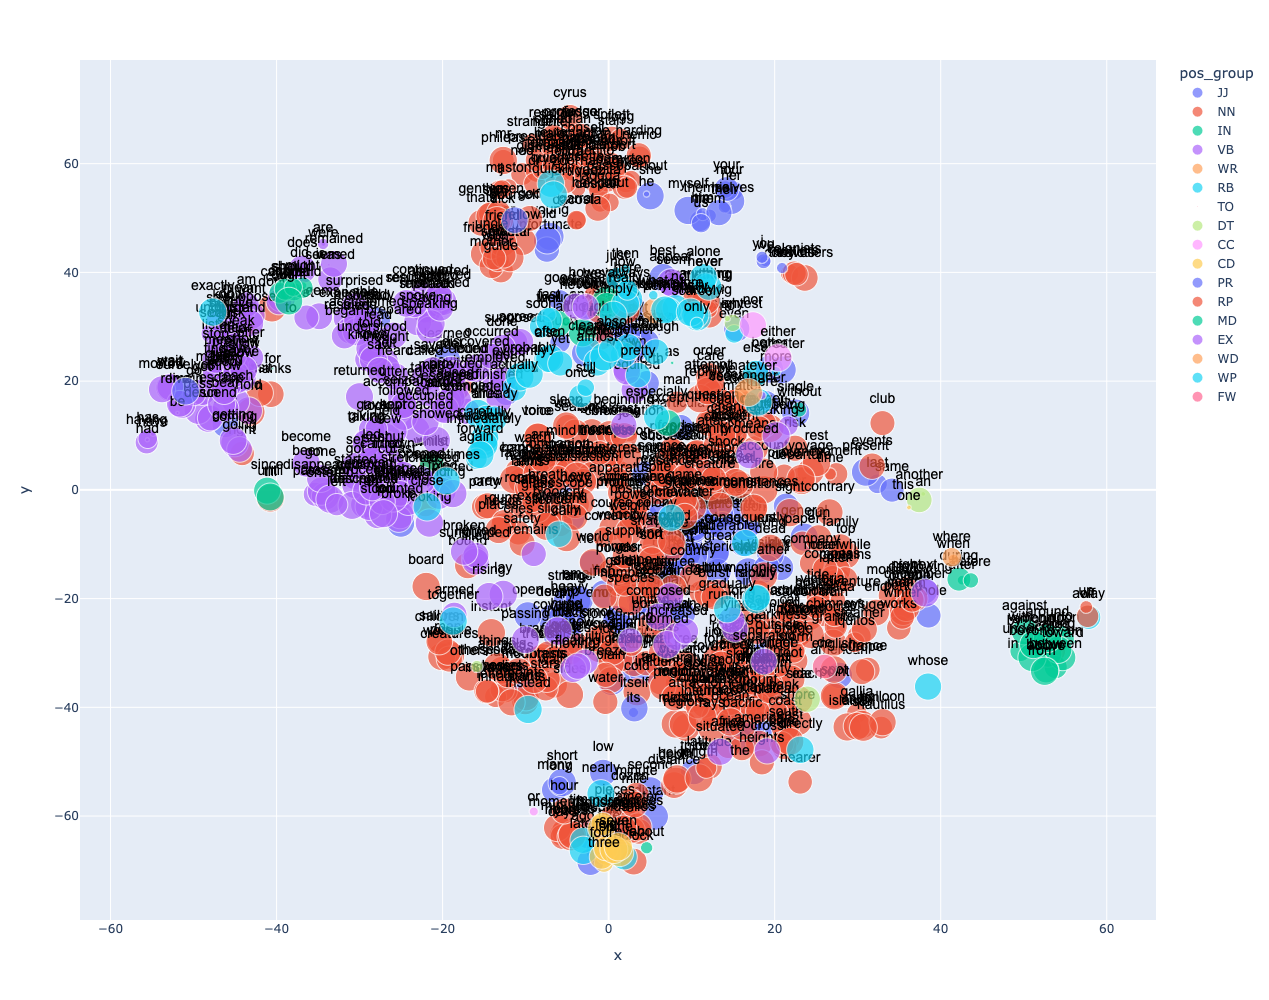

In [48]:
px.scatter(VerneCOORDS.reset_index().sample(1000), 
           'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='dfidf',           
           height=1000, width=1200).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

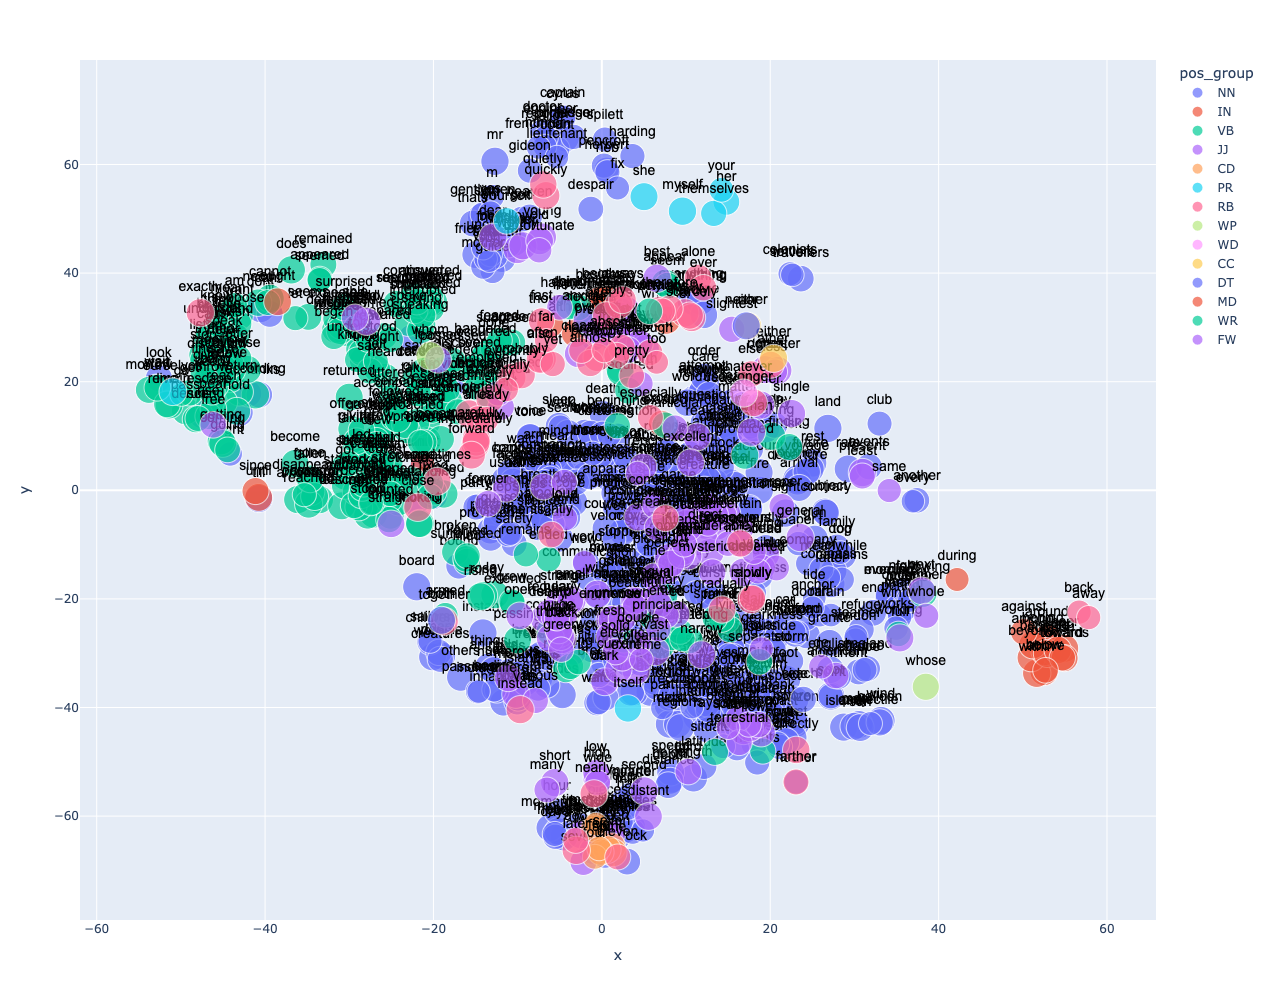

In [49]:
px.scatter(VerneCOORDS.reset_index().sort_values('dfidf', ascending=False).head(1000), 
           'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='dfidf',           
           height=1000, width=1200).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

# Semantic Algebra

## Analogies

$A : B :: C : D? \rightarrow B - A + C = D$


In [50]:
def complete_analogy_Wells(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(WellsModel.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar_Wells(positive, negative=None):
    return pd.DataFrame(WellsModel.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [51]:
def complete_analogy_Verne(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(VerneModel.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar_Verne(positive, negative=None):
    return pd.DataFrame(VerneModel.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [52]:
complete_analogy_Verne('earth', 'man', 'moon', 3)

term       sim
0         word  0.657755
1     stranger  0.619873
2  unfortunate  0.612732

In [53]:
complete_analogy_Verne('earth', 'moon', 'father', 3)

term       sim
0   master  0.866964
1  servant  0.850697
2    uncle  0.821942

In [54]:
complete_analogy_Wells('earth', 'moon', 'father', 3)

term       sim
0  throat  0.708959
1    fate  0.686728
2   youth  0.668523

In [55]:
get_most_similar_Wells('moon')

term       sim
0  surface  0.732525
1    earth  0.714913
2   empire  0.713538
3      sea  0.695204
4   church  0.687824
5  streets  0.682088
6     park  0.668066
7   valley  0.663580
8     town  0.662850
9     area  0.654844

In [56]:
get_most_similar_Verne('moon')

term       sim
0       earth  0.874645
1         sun  0.854547
2  projectile  0.827951
3      gallia  0.773301
4    nautilus  0.754869
5        wind  0.748578
6      island  0.725103
7       coast  0.695682
8  attraction  0.693881
9       globe  0.677147

In [57]:
get_most_similar_Verne('excitement')

term       sim
0      blood  0.882156
1   profound  0.860480
2     closed  0.855755
3       hair  0.837984
4    lighted  0.834070
5  telescope  0.828531
6      cries  0.818837
7      glass  0.815437
8       lamp  0.815208
9      cabin  0.808010

In [58]:
get_most_similar_Wells('excitement')

term       sim
0    suggestion  0.847854
1      attitude  0.823189
2        terror  0.818521
3        slight  0.815848
4  astonishment  0.812089
5         flash  0.807065
6        golden  0.806698
7         quick  0.806322
8         shock  0.806222
9      infinite  0.805592

In [59]:
get_most_similar_Wells('earth')

term       sim
0     moon  0.714913
1       on  0.661301
2   either  0.625046
3    beach  0.563063
4    going  0.549277
5  account  0.548960
6     seat  0.548483
7   ground  0.544953
8  america  0.539928
9       go  0.538149

In [60]:
get_most_similar_Verne('earth')

term       sim
0        moon  0.874645
1         sun  0.849102
2       coast  0.779237
3      island  0.778238
4     surface  0.774351
5  attraction  0.766710
6  projectile  0.757129
7       globe  0.739474
8  atmosphere  0.731313
9    interior  0.728551

In [61]:
get_most_similar_Verne('island')

term       sim
0       earth  0.778238
1       coast  0.739933
2        moon  0.725103
3    american  0.690879
4       globe  0.670412
5       point  0.667593
6  atmosphere  0.658434
7  attraction  0.657984
8   continent  0.655530
9         sun  0.627516

In [62]:
get_most_similar_Wells('island')

term       sim
0     roof  0.779010
1      gas  0.775149
2     runs  0.761411
3    court  0.752538
4   sunset  0.748412
5  surface  0.747269
6     yard  0.740424
7     rush  0.738225
8     sand  0.735487
9    grass  0.731262

In [63]:
get_most_similar_Wells('journey')

term       sim
0        field  0.782895
1  terrestrial  0.772410
2       former  0.770204
3        local  0.763729
4     national  0.751949
5        train  0.750633
6    twentieth  0.748768
7      earthly  0.742959
8       sunday  0.741465
9    adventure  0.740954

In [64]:
get_most_similar_Verne('journey')

term       sim
0   departure  0.838141
1      voyage  0.797955
2      search  0.796894
3   situation  0.780336
4      future  0.771244
5     arrival  0.771094
6  expedition  0.763367
7    position  0.759306
8    business  0.757118
9      vessel  0.749624

# Save

In [66]:
WellsW2V.to_csv(f'{data_home}/output/WELLS-W2V.csv')
VerneW2V.to_csv(f'{data_home}/output/VERNE-W2V.csv')
WellsVOCAB.to_csv(f'{data_home}/output/WELLS-VOCAB.csv')
VerneVOCAB.to_csv(f'{data_home}/output/VERNE-VOCAB.csv')
WellsSENTS.to_csv(f'{data_home}/output/WELLS-GENSIM_DOCS.csv')
VerneSENTS.to_csv(f'{data_home}/output/VERNE-GENSIM_DOCS.csv')